In [1]:
# NOTEBOOK IMPORTS
import os, glob, zipfile, warnings
import numpy as np
from tqdm.notebook import tqdm
from shutil import copyfile, rmtree
from datetime import datetime

# IMAGE IMPORTS
import cv2
from PIL import Image

# GIS IMPORTS
import fiona, pyproj
from affine import Affine
from shapely.geometry import shape, mapping, Point, LineString, MultiPolygon
from shapely.ops import transform, nearest_points, snap
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from scipy.spatial import cKDTree

# PLOTTING IMPORTS
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# CUSTOM UTILITIES
from WorldFileUtils import *
from GeometryUtils import *
from icp import *
from DataUtils import *
from FindGrid import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")

C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def getGEOID(CID,):
    # DEALING WITH A COMMUNITY ID (CID)
    if CID >= 9e4:
        output = CIDs[CIDs["CID"] == CID]["GEOID_p"].to_numpy()
    else: # DEALING WITH A COUNTY
        output = np.asarray([CID])
    
    if output.size == 0:
        return None
    return output[0]

def getGeometry(geoid, new_epsg=3857):
    
    project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS(f'EPSG:{new_epsg}'), 
                                          always_xy=True).transform
    
    # DEALING WITH A COMMUNITY ID (CID)
    if geoid >= 9e4:
        output = places[places["GEOID"] == geoid]["geometry"].to_numpy()
    else: # DEALING WITH A COUNTY
        output = counties[counties["GEOID"] == geoid]["geometry"].to_numpy()
    if output.size == 0:
        return None    
    
    output = transform(project, output[0])
    
    return output

def drawGrid(image_t, out):
    # Create a blank image to draw the lines on
    line_image = np.zeros_like(image_t)

    for k, contours in out.items():
        contours = contours.squeeze()
        for i in range(contours.shape[0] - 1):
            start_point = tuple(contours[i, :])
            end_point = tuple(contours[i+1, :])
            color = (255)  # You can change the color (BGR format) as needed
            thickness = 10  # You can adjust the thickness of the line
            line_image = cv2.line(line_image, start_point, end_point, color, thickness)
            
    return line_image > 0

def adjustStep(from_points, coords_ras, kdtree, shear=True, rotation = True, perspective=True):
    
    # CALCULATE NEAREST POINTS AND FIND HOMOGRAPHY
    _, nearest_indices = kdtree.query(from_points)
    to_points = np.array([coords_ras[idx] for idx in nearest_indices])
    new_homography, _ = cv2.findHomography(from_points, to_points, cv2.RANSAC, 10000)
    if not shear:
        scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
        new_homography[0, 0] = scale 
        new_homography[1, 1] = scale
    if not perspective:
        new_homography[2, 0] = 0 
        new_homography[2, 1] = 0 
    if not rotation:
        new_homography[0, 1] = 0 
        new_homography[1, 0] = 0 
    final_points = new_homography @ np.vstack((from_points[:, 0], from_points[:, 1], np.ones(from_points[:, 0].shape)))
    
    return final_points[:2, :].T, new_homography

def find_bbox(binary_image):
    # Find the coordinates of all "True" elements in the binary image
    nonzero_points = cv2.findNonZero(binary_image)

    if nonzero_points is None:
        return None

    # Calculate the bounding rectangle for the "True" elements
    x, y, w, h = cv2.boundingRect(nonzero_points)

    return np.array([x, y, x+w, y+h])

def get_world_file_path(image_path):
    # Get the file extension (e.g., "png", "jpg", "tif")
    file_extension = image_path.split('.')[-1].lower()

    # Define a dictionary to map file extensions to world file extensions
    extension_mapping = {
        'png': 'pgw',
        'jpg': 'jpw',
        'jpeg': 'jpw',  # You can add more extensions if needed
        'tif': 'tfw',
        'tiff': 'tfw',
    }

    # Check if the file extension is in the mapping
    if file_extension in extension_mapping:
        # Replace the file extension with the corresponding world file extension
        world_file_extension = extension_mapping[file_extension]

        # Create the world file path by replacing the image file extension with the world file extension
        world_file_path = os.path.splitext(image_path)[0] + '.' + world_file_extension

        return world_file_path
    else:
        return None  # Unsupported file extension
    
def plotICP(reprojected_points, plot_skip=2, ):
    icp_iterations = len(reprojected_points)
    fig, ax = plt.subplots()
    colormap = plt.get_cmap('RdYlGn') 

    ax.scatter(coords_shp_proc[:, 0], coords_shp_proc[:, 1], color=colormap(0), s=0.5)
    ax.scatter(coords_ras_proc[:, 0], coords_ras_proc[:, 1], color="black", s=0.5)

    for i in np.arange(plot_skip, icp_iterations, plot_skip):
        ax.scatter(reprojected_points[i][:, 0], reprojected_points[i][:, 1], color=colormap(i / icp_iterations), s=0.1)
    return ax

In [3]:
np.arange(2, 10, 2)

array([2, 4, 6, 8])

IO dirs

In [4]:
username = os.getlogin()

if username == 'fhacesga':
    base_input_path   = r"D:\FloodChange\AAA_HistoricalDownload"
    base_output_path  = r"C:\Users\\"+username+"\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\ReferenceDatasets\\"
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\ReferenceDatasets\\"
 
CIDs     = pd.read_csv(f"{ref_dir}CountyCIDs.csv", index_col=0)
counties = gpd.read_file(f"{ref_dir}Counties.shp")
places   = gpd.read_file(f"{ref_dir}Places.shp")

counties["GEOID"] = counties["GEOID"].astype(np.int32)
places["GEOID"]   = places["GEOID"].astype(np.int32)

Create working dir and unzip all files

In [5]:
# proc_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-08_16-35-58"
proc_dir = None
proc_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-11_14-00-13"

In [6]:
if proc_dir is None:
    datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    proc_dir     = os.path.join(base_output_path, datetime_str)
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    print(proc_dir)
    os.makedirs(proc_dir)
    os.makedirs(unzipped_dir)
    os.makedirs(outputs_dir)
    extractZipFiles(base_input_path, unzipped_dir)
else:
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    rmtree(outputs_dir)
    os.makedirs(outputs_dir)

In [7]:
image_files = glob.glob(f"{unzipped_dir}/*")
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files = glob.glob(f"{unzipped_dir}/*IND*")

index_files.extend(filtered_files)
index_files = pd.DataFrame(index_files, columns=["FilePath"])

In [9]:
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)
index_files["GEOID"] = index_files["Location"].apply(getGEOID)
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)

C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-11_14-00-13\Inputs\480233IND0_0382.jpg
Using 480233 to find as many tiles as possible


  0%|          | 0/4 [00:00<?, ?it/s]

Highest Hierarchy: 2 in 7 contours
Assigning Points
Scale: 0.97 Offset: 6.10
Scale: 1.00 Offset: 1.30


<Figure size 640x480 with 0 Axes>

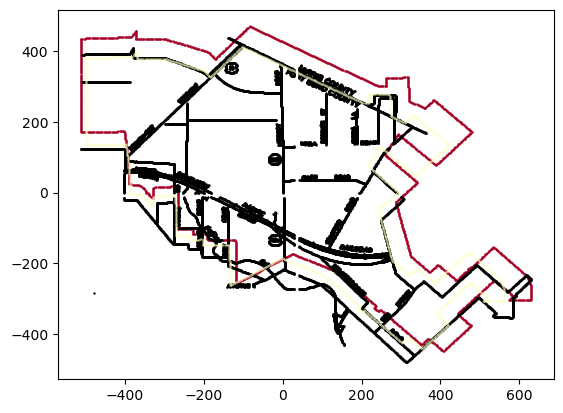

[[ 7.26089125e+00  0.00000000e+00 -1.06495179e+07]
 [ 0.00000000e+00 -7.41474228e+00  3.46956360e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-11_14-00-13\Inputs\480287IND0_0281.jpg
Using 480287 to find as many tiles as possible


  0%|          | 0/3 [00:00<?, ?it/s]

Highest Hierarchy: 1 in 11 contours
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((1374.001774828856 2034.500501737333, 1871 2034, 1870.71601135845 1751.99927894123, 1373.001774828856 1752.500501737333, 1374.001774828856 2034.500501737333)), POLYGON ((1373.001774828856 1752.500501737333, 876.9999999999999 1753, 877.2839886415495 2035.00072105877, 1374.001774828856 2034.500501737333, 1373.001774828856 1752.500501737333)))
Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((1374.001768557398 1751.500501743648, 1871 1751, 1870.715004310126 1467.999279955377, 1373.001768557398 1468.500501743648, 1374.001768557398 1751.500501743648)), POLYGON ((1373.001768557398 1468.500501743648, 877 1469, 877.2849956898737 1752.000720044623, 1374.001768557398 1751.500501743648, 1373.001768557398 1468.500501743648)))
Failure! Results will be inaccura

<Figure size 640x480 with 0 Axes>

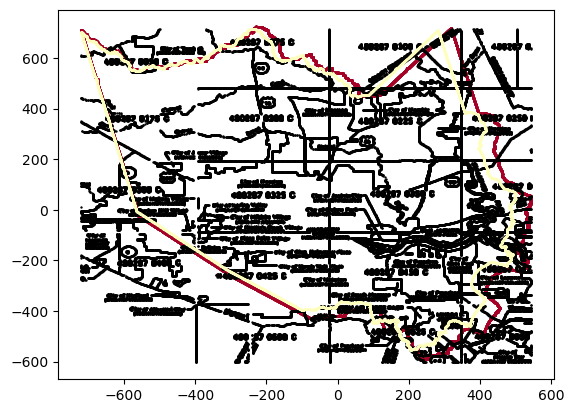

[[ 9.80146586e+01  0.00000000e+00 -1.07375379e+07]
 [ 0.00000000e+00 -6.95487975e+01  3.62264719e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-11_14-00-13\Inputs\480287IND0_0288.jpg
Using 480287 to find as many tiles as possible


  0%|          | 0/6 [00:00<?, ?it/s]

Highest Hierarchy: 1 in 60 contours
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((3474 2450.169077757685, 2920.485234668343 2450.66954318746, 2921 3020, 3474 3019.5, 3474 2450.169077757685)), POLYGON ((3474 3019.5, 4028.254067690888 3018.998866123245, 4027.739302359232 2449.668409310706, 3474 2450.169077757685, 3474 3019.5)))
Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((3662 2159.728155339806, 3662 1870, 3287 1870, 3287 2159.273058252427, 3662 2159.728155339806)), POLYGON ((3287 2159.273058252427, 3287 2450, 3662 2450, 3662 2159.728155339806, 3287 2159.273058252427)))
Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((4037 1735.913616398243, 4037 1316, 3662 1316, 3662 2022.791361639824, 4037 1735.91

<Figure size 640x480 with 0 Axes>

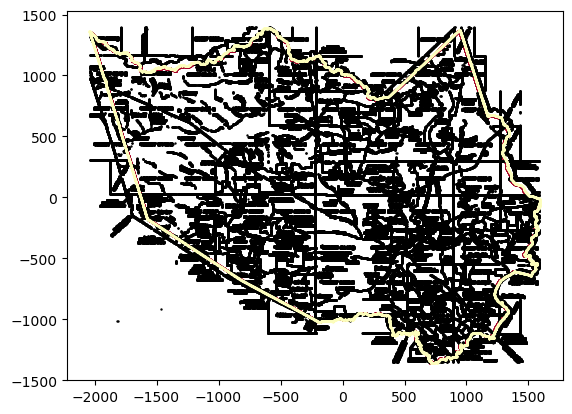

[[ 3.21057434e+01  0.00000000e+00 -1.07058765e+07]
 [ 0.00000000e+00 -3.12754122e+01  3.54134415e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-11_14-00-13\Inputs\480287IND0_0382.jpg
Using 480287 to find as many tiles as possible


  0%|          | 0/3 [00:00<?, ?it/s]

Highest Hierarchy: 2 in 16 contours
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((1256.801150667308 2325.336199685782, 2003.000598174004 2324.667562188016, 2002.495516906646 1760.996867816392, 1440.925760787072 1761.500066522593, 1256.801150667308 2325.336199685782)), POLYGON ((1440.925760787072 1761.500066522593, 883.0000000000001 1762, 883.5050812673583 2325.670694371624, 1256.801150667308 2325.336199685782, 1440.925760787072 1761.500066522593)))
Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified
Assigning Points
Scale: 0.92 Offset: 10.03
Scale: 1.00 Offset: 1.23


<Figure size 640x480 with 0 Axes>

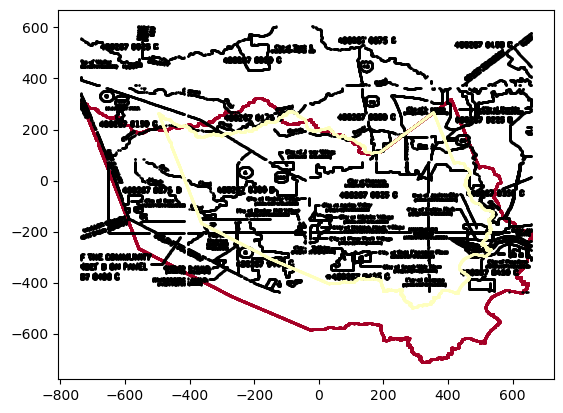

[[ 1.14967449e+02  0.00000000e+00 -1.06913296e+07]
 [ 0.00000000e+00 -1.13965271e+02  3.77193748e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-11_14-00-13\Inputs\480287IND0_0985.jpg
Using 480287 to find as many tiles as possible


  0%|          | 0/6 [00:00<?, ?it/s]

Highest Hierarchy: 2 in 49 contours
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((3654 2748.446866485014, 3654 2464, 2920 2464, 2920 3036, 3283.712280701754 3036, 3654 2748.446866485014)), POLYGON ((3283.712280701754 3036, 3654 3036, 3654 2748.446866485014, 3283.712280701754 3036)))
Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((4027.532239789908 2181.00339907696, 4029.059080267074 1897.011070324016, 3657.059080267074 1895.011070324016, 3655.526884627915 2179.999459207779, 4027.532239789908 2181.00339907696)), POLYGON ((3655.526884627915 2179.999459207779, 3654 2463.999999999999, 4025.999999999999 2465.999999999999, 4027.532239789908 2181.00339907696, 3655.526884627915 2179.999459207779)))
Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified
Found too many names! Splitting along long

<Figure size 640x480 with 0 Axes>

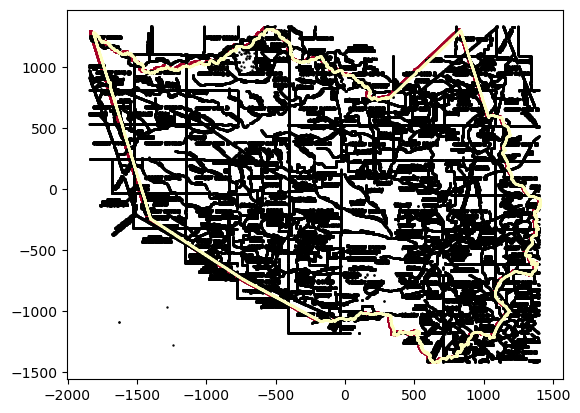

[[ 3.64065747e+01  0.00000000e+00 -1.07080847e+07]
 [ 0.00000000e+00 -3.16861298e+01  3.54254903e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-11_14-00-13\Inputs\480296IND0_0982.jpg
Using 480296 to find as many tiles as possible


  0%|          | 0/5 [00:00<?, ?it/s]

Highest Hierarchy: 1 in 35 contours
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((1897.001440917677 2759.499998433785, 2357 2759, 2356.622825351104 2411.999323015922, 1896.001440917677 2412.499998433785, 1897.001440917677 2759.499998433785)), POLYGON ((1896.001440917677 2412.499998433785, 1436 2413, 1436.377174648896 2760.000676984077, 1897.001440917677 2759.499998433785, 1896.001440917677 2412.499998433785)))
Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified
Assigning Points
Scale: 0.98 Offset: 6.85
Scale: 0.99 Offset: 8.26


<Figure size 640x480 with 0 Axes>

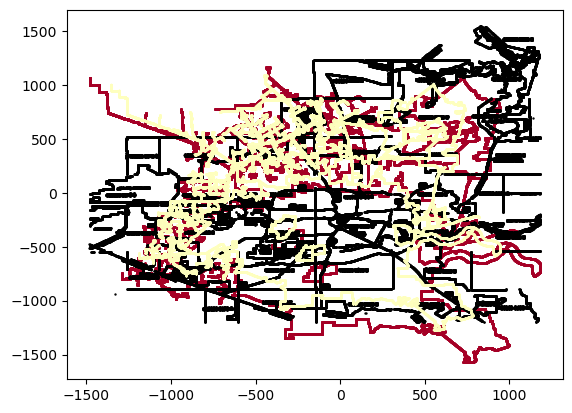

[[ 4.52300633e+01  0.00000000e+00 -1.07050478e+07]
 [ 0.00000000e+00 -3.44707637e+01  3.56896700e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-11_14-00-13\Inputs\480296IND0_0985.jpg
Using 480296 to find as many tiles as possible


  0%|          | 0/5 [00:00<?, ?it/s]

Highest Hierarchy: 5 in 34 contours
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((1901.001416426185 3166.499998443488, 2356 3166, 2355.612087172941 2812.999327376733, 1900.001416426185 2813.499998443488, 1901.001416426185 3166.499998443488)), POLYGON ((1900.001416426185 2813.499998443488, 1445 2814, 1445.387912827058 3167.000672623267, 1901.001416426185 3166.499998443488, 1900.001416426185 2813.499998443488)))
Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((1901.001420450111 2812.499998439066, 2356 2812, 2355.613186072714 2459.999326169151, 1900.001420450111 2460.499998439066, 1901.001420450111 2812.499998439066)), POLYGON ((1900.001420450111 2460.499998439066, 1445 2461, 1445.386813927287 2813.000673830849, 1901.001420450111 2812.499998439066, 1900.001420450111 2460.499998439066)))
Failure! Results will be inaccurate due to

TypeError: 'NoneType' object is not subscriptable

<Figure size 640x480 with 0 Axes>

In [9]:
for i, row in index_files.iterrows():
    
    print(row["FilePath"])
    
    # READ FILES AND RUN CLASSIFICATIONS
    image = cv2.imread(row["FilePath"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # SAVE IMAGE TO OUTPUT DIRECTORY
    output_image = os.path.join(outputs_dir, os.path.basename(row["FilePath"]))
    copyfile(row["FilePath"], output_image)
    
    # GET WHICHEVER POLYGON IS THE LARGEST IN THE ROW'S GEOMETRY AND SIMPLIFY
    if row["geometry"] is None:
        continue
    elif isinstance(row["geometry"], MultiPolygon):
        largest_polygon_area = np.argmax([a.area for a in row["geometry"]])
        largest_polygon = row["geometry"][largest_polygon_area].simplify(tolerance=20)
        largest_polygon = largest_polygon.boundary
    else:
        largest_polygon = row["geometry"].boundary
        
    
    
    # CONVERT POLYGON TO POINTS
    length = largest_polygon.length # POLYGON LENGTH
    point_boundary_list = list()    # OUTPUT POINT LIST
    for distance in tqdm(range(0,int(length),20), disable=True):         # INTERPOLATE THROUGH ALL OF LENGTH
        point = largest_polygon.interpolate(distance)   
        point_boundary_list.append(point)
    point_boundary_gdf = gpd.GeoDataFrame(geometry=point_boundary_list)
    
    # FIND THE GRID INSIDE THE IMAGE
    out = FindGrid(row["FilePath"], verbose=False)

    # PLOT IMAGE
    plot_image = np.dstack([image, image, image])
    contours = []
    
    
    # LOOP THROUGH CONTOURS AND ADD THEM TO IMAGE
    for k, v in out.items():
        cv2.drawContours(plot_image, v, -1, (0, 255, 0), 3)
        contours.append(contours_to_shapely_polygons(v))
        
    # CALCULATE BOUNDS OF CONTOURS ON IMAGE
    bounds_panels = MultiPolygon(contours).bounds
    bounds_panels = [int(i) for i in bounds_panels]

    # CREATE MASK USING GRID 
    mask = np.zeros(image.shape)
    mask[bounds_panels[1]+50:bounds_panels[3]-50, bounds_panels[0]+50:bounds_panels[2]-50] = 1
    mask_1 = drawGrid(image, out)          # GRID MASKING
    mask = np.logical_and(~mask_1, mask)   # MERGE MASKS
    
    # FLIP IMAGE AND MASK IT
    image = 255 - image
    image_t = image * mask
    
    # RASTER BOUNDS
    get_bounds_image = np.where(np.asarray(cv2.erode(image_t, np.ones((3,3), np.uint8)) > 50), 1, 0)
    # plt.imshow(get_bounds_image)
    # plt.show()
    
    # print(get_bounds_image)
    bounds_panels_postfilter = find_bbox(get_bounds_image)
    bounds_panels = [i for i in bounds_panels_postfilter]
                                  
    # SHAPEFILE BOUNDS
    shp_bounds = [i for i in largest_polygon.bounds]

    print("Assigning Points")
    # INITIAL TRANSFORM
    from_points   = np.array([[bounds_panels[0], bounds_panels[1]], 
                   [bounds_panels[0], bounds_panels[3]],
                   [bounds_panels[2], bounds_panels[1]],
                   [bounds_panels[2], bounds_panels[3]]])

    to_points = np.array([[shp_bounds[0], shp_bounds[1]], 
                   [shp_bounds[0], shp_bounds[3]],
                   [shp_bounds[2], shp_bounds[1]],
                   [shp_bounds[2], shp_bounds[3]]])

    initial_transform = cv2.findHomography(from_points, to_points, cv2.RANSAC, 1000)
    original_homography = initial_transform[0]
    inverse_transform = np.linalg.inv(original_homography)

    # CONVERT THINNED IMAGE TO POINTS
    thin_image = cv2.ximgproc.thinning(image_t.astype(np.uint8), thinningType=cv2.ximgproc.THINNING_GUOHALL)
    y, x = np.where(thin_image[::-1, :])                   # GET COORDINATES OF EVERY 
    image_points = np.vstack((x, y, np.ones(x.shape)))     # STACK X, Y, AND Z COORDINATES
    # outputs = original_homography @ image_points           # TRANSFORM COORDINATES USING ESTIMATES
    
    # TRANSFORM SHAPEFILE POINTS INTO IMAGE COORDINATE SYSTEM
    point_geometry = [[point.geometry.x, point.geometry.y, 1] for i, point in point_boundary_gdf.iterrows()]
    point_geometry = inverse_transform @ np.array(point_geometry).T
    
    # COORDINATE HANDLING
    coords_shp = point_geometry.T
    coords_ras = np.vstack((image_points[0, :], image_points[1, :], np.ones(image_points[1, :].shape))).T
    
    # IMAGE ORIGIN COORDINATE SYSTEM TO IMAGE CENTER COORDINATE SYSTEM
    offsets = np.mean(coords_ras, axis=0)
    x_offset = offsets[0]
    y_offset = offsets[1]

    coords_shp_proc = np.vstack((coords_shp[:, 0] - x_offset, coords_shp[:, 1] - y_offset)).T
    coords_ras_proc = np.vstack((coords_ras[:, 0] - x_offset, coords_ras[:, 1] - y_offset)).T
    
    # FAST SEARCH STRUCTURE
    kdtree = cKDTree(coords_ras_proc)
    
    # ITERATIVE CLOSEST POINT
    reprojected_points = []
    compounded_homography = np.eye(3)
    proc_points = coords_shp_proc
    
    # ITERATE
    for i in tqdm(range(20), disable=True):
        # TAKE ADJUSTMENT STEP
        out, new_homography = adjustStep(proc_points, coords_ras_proc, kdtree,
                                        shear=False, rotation=False, perspective=False)
        compounded_homography = compounded_homography @ new_homography
        reprojected_points.append(out)
        proc_points = out
        if i % 10 == 0:
            scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
            offset = np.sqrt((new_homography[1, 2] ** 2 + new_homography[0, 2] ** 2) / 2)

            print(f"Scale: {scale:.2f} Offset: {offset:.2f}")
    
    plotICP(reprojected_points, plot_skip=10, )
    plt.show()
    
    # REVERSE Y AXIS
    rev_y_axis = np.array([[1, 0, 0],
                           [0,-1, 0],
                           [0, 0, 1]])

    # move = original_homography @ np.array([0, image_t.shape[0], 0])
    translation = np.eye(3)
    translation[1, 2] = image_t.shape[0]

    adjustment = np.linalg.inv(compounded_homography.copy())
    adjustment[0, 2] = -1 * adjustment[0, 2]
    adjustment[1, 2] = -1 * adjustment[1, 2]
    # temp = adjustment[0, 2]
    # adjustment[0, 2] = adjustment[1, 2]
    # adjustment[1, 2] = temp
    output_transform = original_homography @ adjustment @ translation @ rev_y_axis 
    print(output_transform)
    # output_transform = original_homography @ translation @ rev_y_axis 
      
    output_affine = Affine(*output_transform.flatten()[:6])
    write_world_file_from_affine(output_affine, get_world_file_path(output_image))